In [1]:
from typing import Any, Optional

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.colors as colors

import anguilla.hypervolume as hv

from anguilla.selection import indicator_selection
from anguilla.indicators import HypervolumeIndicator

In [2]:
def line(m, b):
    """Compute a line"""
    return lambda x: m * x + b

def curve(a, b):
    """Compute a quadratic curve"""
    return lambda x: a * x * x + b

def get_objective_points(domain, *fns):
    """Evaluate the functions on the domain to create a population."""
    size = len(domain) * len(fns)
    points = np.empty((size, 2))
    i = 0
    for fn in fns:
        points[i : i + len(domain), 0] = domain
        points[i : i + len(domain), 1] = fn(domain)
        i += len(domain)
    return points

def contributions_plot(points: np.ndarray, contributions: np.ndarray,
                       deleted = None,
                       selected = None,
                       title = "") -> Any:
    fig = plt.figure(figsize=(8, 6))
    axs = fig.subplots(1, 1)
    # We assume the points are ordered from left-most extreme point
    # to right-most extreme point
    min_contrib = np.min(contributions[1:-1]) 
    max_contrib = np.max(contributions[1:-1])
    contribs_cmap = plt.cm.get_cmap("jet", len(contributions) - 2)
    # We plot the extreme points as stars since they have infinite contribution
    for i, point in enumerate(points):
        if i == 0 or i == len(points) - 1:
            axs.plot(points[i, 0], points[i, 1], marker="*", markersize=12,
                     color="black", markerfacecolor="black", linestyle="", zorder=2)
        else:
            contrib_color = contribs_cmap(contributions[i] / max_contrib)
            rectangle = Rectangle(points[i],
                                  width=points[i+1, 0] - points[i, 0],
                                  height=points[i-1, 1] - points[i, 1],
                                  facecolor=contrib_color,
                                  alpha=1.0,
                                  zorder=1)
            axs.add_patch(rectangle)
            axs.plot(points[i, 0], points[i, 1], marker="+", markersize=12, color="black", linestyle="", zorder=2)
    if deleted is not None:
        axs.plot(deleted[:, 0], deleted[:, 1], marker="+", markersize=12, color="red", linestyle="", zorder=2)
    if selected is not None:
        axs.plot(selected[:, 0], selected[:, 1], marker="x", markersize=12, color="green", linestyle="", zorder=2)
    axs.set_xlabel("First objective")
    axs.set_ylabel("Second objective")
    axs.set_title(title)
    cbar = fig.colorbar(plt.cm.ScalarMappable(colors.Normalize(min_contrib, max_contrib), cmap=contribs_cmap), ax=axs)
    cbar.set_label("Contribution", rotation=270, labelpad=10)
    return fig

In [3]:
def non_dominated_indicator_selection(points, n):
    # Assumes an array of non-dominated points and selects the n best
    # We need to remove the n points with least contribution
    deleted = []
    for i in range(n):
        contributions = hv.contributions(points)
        sorted_idx = np.argsort(contributions)
        deleted.append(points[sorted_idx[0]])
        fig = contributions_plot(points, contributions, title=f"Iteration {i+1}", deleted=np.array(deleted))
        points = np.delete(points, sorted_idx[0], axis=0)
    return np.array(deleted)

def implementation_indicator_selection(points, n):
    # The implementation used in Anguilla
    indicator = HypervolumeIndicator()
    selected, _ = indicator_selection(indicator, points, n)
    return selected

## Example 1

We first plot the selection at each iteration.

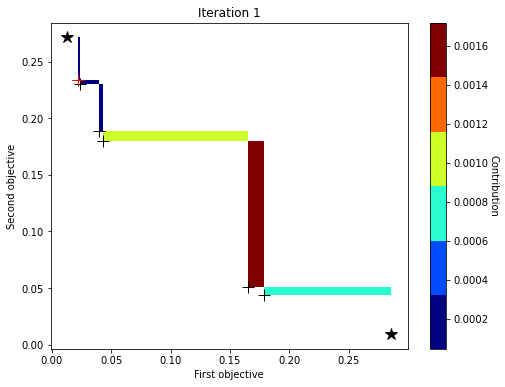

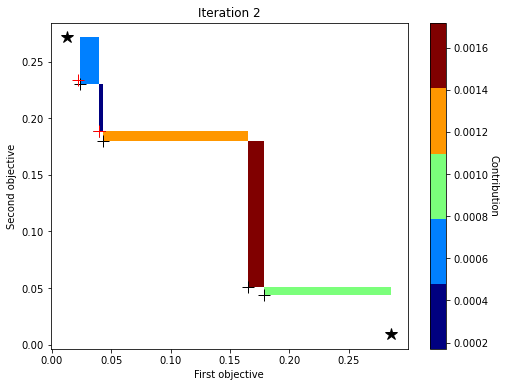

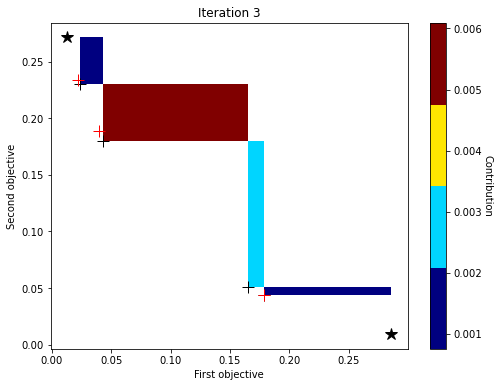

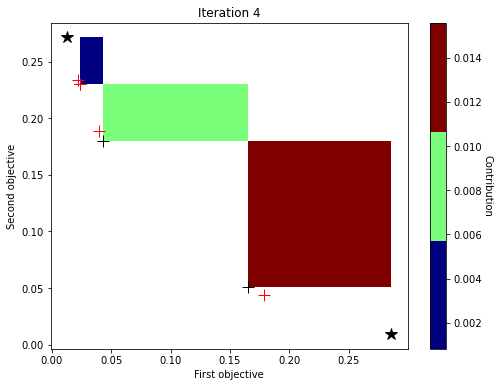

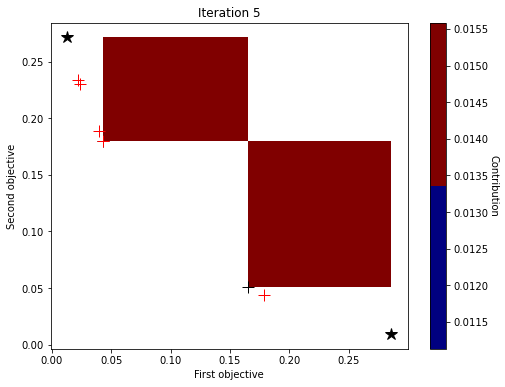

In [4]:
points = np.array([[0.01245897, 0.27127751],
       [0.02213313, 0.23395707],
       [0.0233907 , 0.22994154],
       [0.0392689 , 0.1886141 ],
       [0.04339422, 0.17990426],
       [0.16521067, 0.05107939],
       [0.17855283, 0.0440614 ],
       [0.28619405, 0.00950565]])

deleted = non_dominated_indicator_selection(points, 5)

Now we plot the expected deleted points and the selected points by the implementation.

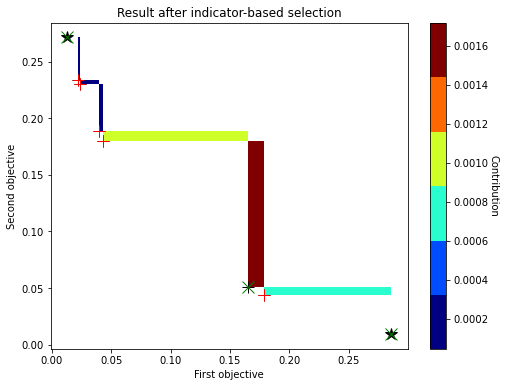

In [5]:
selected = implementation_indicator_selection(points, len(points) - 5)
fig = contributions_plot(points, hv.contributions(points),
                         title="Result after indicator-based selection",
                         deleted=deleted, selected=points[selected])

## Example 2

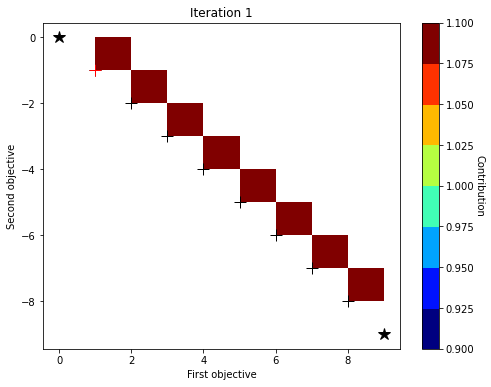

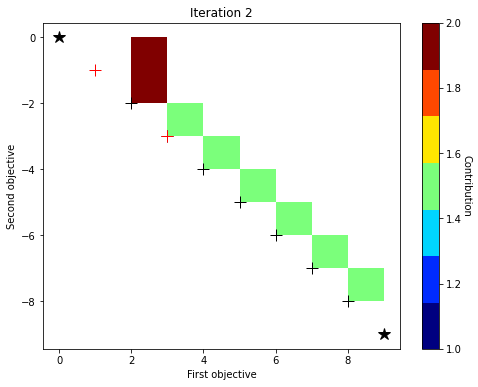

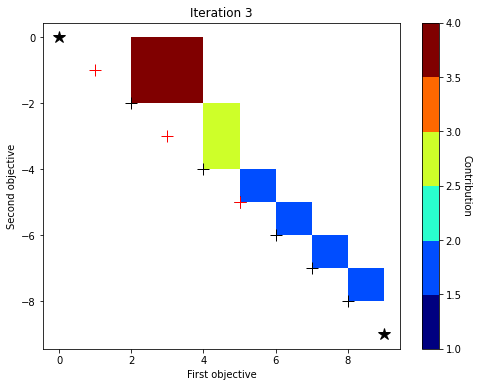

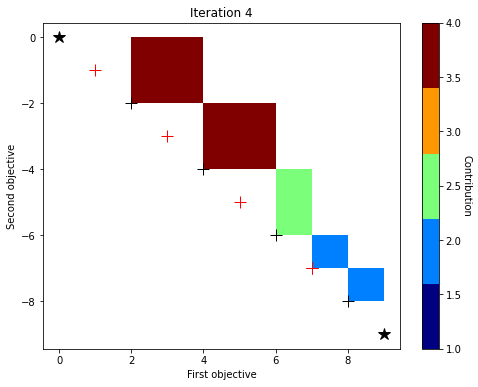

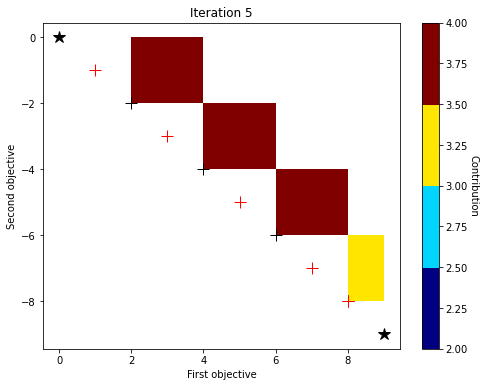

In [6]:
size = 10
points = get_objective_points(np.arange(0, size), line(-1, 0))

deleted = non_dominated_indicator_selection(points, 5)

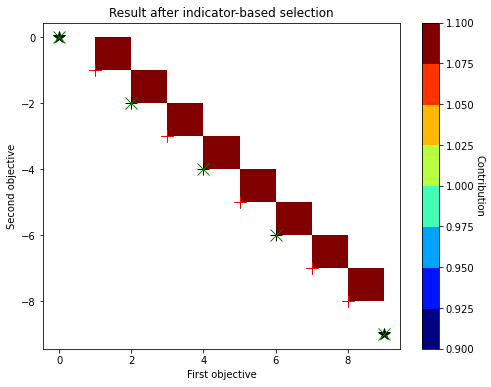

In [7]:
selected = implementation_indicator_selection(points, len(points) - 5)
fig = contributions_plot(points, hv.contributions(points),
                         title="Result after indicator-based selection",
                         deleted=deleted, selected=points[selected])